# Error-tolerant BS-based circuit

In this notebook, we aim  at presenting an alternative form of "generic" interferometers using  a BS-based structure as a building block rather than a MZI (Mach-Zehnder interferometer) as a building block. BS-based circuits seem to be more tolerant to manufacturing errors and losses according to Fldzhyan et al. *Optimal design of error-tolerant reprogrammable multiport interferometers*, [Optics Letters](https://doi.org/10.1364/OL.385433), 45(9):2632–2635 (2020)

## Introduction 

### Parameters

The goal is to successfully implement a random unitary $U_{target}$ by varying parameters of a fix "generic" interferometer $U_{interf}$. For instance, the Reck decomposition [2] has MZI as building block and by varying the angle of variable phase shifts, any unitary can be implemented. However, as we will see, this is only true when the MZI building block have perfect 50:50 beam-splitters which is not realistic in practice due to manufacturing errors. To see this, we will introduce a parameter $\alpha$ which characterise the error caused by the imbalance of the static BS due to imperfect realisation. And we will investigate how this impacts the correct implementation of any unitary (drawn from the Haar measure) by minimising the infedility (or maximising the fidelity) between the target unitary $U_{target}$ and its implementation $U_{interf}$.
We will compare this with the BS-based approach [1].

#### Initialisation

In [1]:
import datetime
import time
import numpy as np
from scipy.optimize import basinhopping
import random

import perceval as pcvl
import perceval.components.base_components as comp
from perceval.components import Circuit
import os
import math
from tqdm.notebook import tqdm_notebook

We start by defining all parameters used in the program later on:

In [2]:
N=5
n_try=10
n_iter=3
n_process=8
angle_min=-15
angle_max=30
angle_step=2
n_unitary=300
logfilebs='bsbasednotebook-opt'
logfilemzi='mzibasednotebook-opt'

## 1. Perceval implementation of the BS-based interferometer

We start by describing the circuit as defined in [1] using `Circuit.generic_interferometer()`. The circuit is built with an arrangement of single static beam-splitters with a variable phase shifter on the same leg. It also starts with phase-shifters on each mode at the beginning.

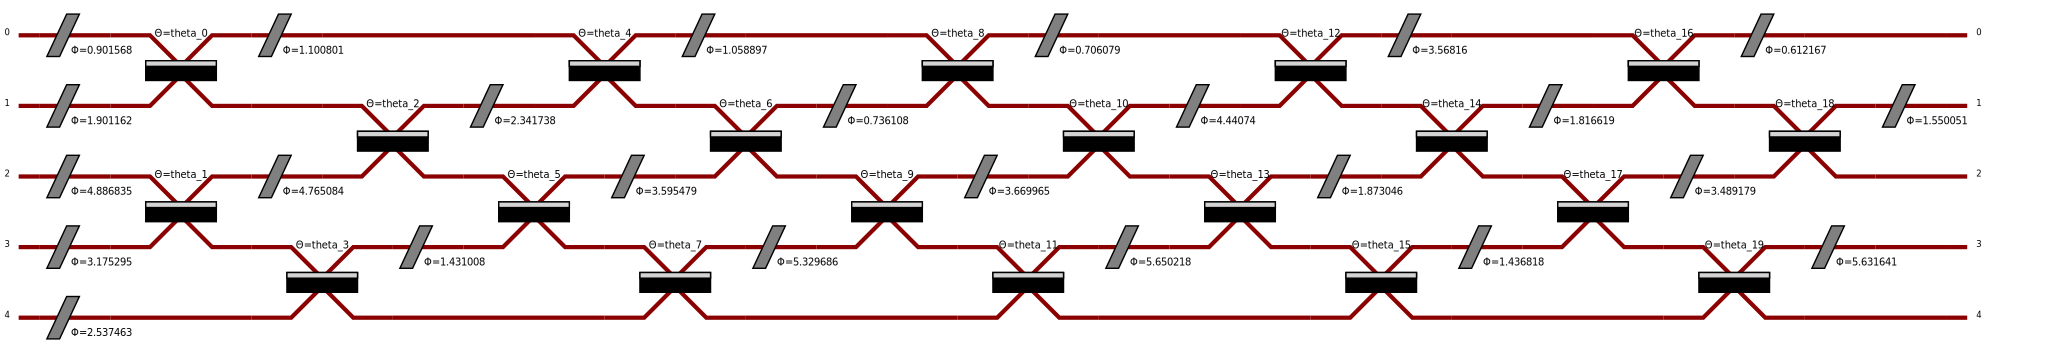

In [3]:
bs = Circuit.generic_interferometer(N,
                                         lambda idx : comp.GenericBS(theta=pcvl.P("theta_%d"%idx))//(0, comp.PS(phi=np.pi*2*random.random())),
                                         shape="rectangle",
                                         depth = 2*N,
                                         phase_shifter_fun_gen=lambda idx: comp.PS(phi=np.pi*2*random.random()))
pcvl.pdisplay(bs, recursive = True)


### Minimizing infidelity

We first define a "loss" function which computes the infidelity between the target unitary and the implemented unitary. The fidelity evaluates the performance of the multiport interferometers via $F=\frac{\lvert \mathrm{Tr} ({U_{target}}^{\dagger} U_{interf}) \rvert²}{N\mathrm{Tr}({U_{target}}^{\dagger} U_{target})}$ where $U_{target}$ is the target matrix and $U_{interf}$ the actual unitary matrix realized by the interferometer and where N is the size of the matrices.

In [4]:
def infidelity(c, U_target, params, params_value):
    """
    inputs: 
    *c* type: circuit from pcvl.Circuit()
        role: generic interferometer to optimize 
    *U_target* type: matrix from pcvl.Matrix.random_unitary()
               role: unitary matrix randomly chosen
    *params* type: parameters from c.get_parameters()
             role: get the parameters associated to the circuit c 
    *params_value* type: int
                   role: value of the parameters

    outputs: 
    *infidelity value* type: int
                       role: infidelity value between U and U0
    """
    for idx, p in enumerate(params_value):
        params[idx].set_value(p) #give a value to each params
    U = c.compute_unitary(use_symbolic=False) #
    U_dag = np.transpose(np.conjugate(U))
    f = abs(np.trace(U_dag @ U_target)) ** 2 / (c.m * np.trace(U_dag @ U))
    return 1 - abs(f)

### Basinhopping algorithm

Then, we want to optimise over the angles of the phase-shifters $\phi$ comprising $U_{interf}$ by minimizing the infidelity $1 - F$ [1]. To do so, we use a numerical optimisation algorithm based on the basinhopping algorithm to explore the space of phases and minimize $1-F$ for a specific value of manufacturing error $\alpha$. We then vary $\alpha$ to see how robust to manufacturing errors our scheme is.

In [5]:
def calculate_angle(index_unitary,U_target,alpha):
    """
    inputs:
    *index_unitary* type: int
                    role: index on the number of unitary matrices 
    *U_target* type: matrix from pcvl.Matrix.random_unitary()
               role: unitary matrix randomly chosen
    *alpha* type: int
            role: angle error due to manufacturing 

    outputs:
    *infidelity min* type: int
                     role: min value of infidelity
    """
    start = time.time()
    c = Circuit.generic_interferometer(N,
                                            lambda idx: (comp.GenericBS(theta=(45+alpha)/180*np.pi)
                                                            // (0, comp.PS(phi=pcvl.P("phi_m%d" % idx)))),
                                            depth=2*N,
                                            phase_shifter_fun_gen=lambda idx: comp.PS(phi=pcvl.P("phi_r%d" % idx)))
    params = c.get_parameters()     #We get the parameters of the circuit we have just created
    
    infidelities = []

    for _ in range(n_try):          #We do a number of tests
        init_params = np.random.randn(len(params)) 
        res = basinhopping(lambda x: infidelity(c, U_target, params, x), init_params, stepsize=0.1, niter=n_iter) #the algorithm is looking for a global minimum of infidelity
        infidelities.append(res.fun) #fun is the value of the function at the solution
    return min(infidelities)

Based on the definition of the loss function, we now explore the space of phases to obtain a correct implementation of the target unitary with our BS-based scheme. We then reiterate the following function for various error parameter $\alpha$.

In [6]:
n_angles = (abs(angle_min)+abs(angle_max))/angle_step

def discovery_unitary(index_unitary):
    """
    inputs:
    *param index_unitary* type: int
                          role: index on the number of unitary matrices
    outputs:
    type: list of int
    role: infidelities for all alpha angles
    """
    np.random.seed(int(10000*time.time()+os.getpid()) & 0xffffffff) #not necessary here, but when we run our program on several cores, this line allows us to generate different unit matrices at the same time.
    U_target = pcvl.Matrix.random_unitary(N)                        #generates the unit random matrix
    l_infidelities = []
    M=angle_min + math.ceil((angle_max-angle_min)/angle_step)*angle_step + 1

    for alpha in tqdm_notebook(range(angle_min,M,angle_step), desc = "Angle progress bar unitary {}".format(index_unitary+1), leave=False):
        l_infidelities.append(calculate_angle(index_unitary, U_target, alpha)) 
    return l_infidelities
    
try:
    os.remove("%s-%d.log" % (logfilebs,N)) #To avoid having data on our file that we don't want, we delete the data from previous runs
except OSError:
    pass

for index_unitary in tqdm_notebook(range(n_unitary), desc = "Unitary progress bar"):
    result = discovery_unitary(index_unitary)
    e = datetime.datetime.now()
    with open("%s-%d.log" % (logfilebs,N), "a") as f:    #we create our file
        f.write(e.strftime("%Y-%m-%d %H:%M:%S")+"\t")    #we add the date and the hour of calculation             
        f.write("\t".join(["%g"%inf for inf in result])) #we add the list of infidelities returned by discovery_unitary()
        f.write("\n")

Unitary progress bar:   0%|          | 0/300 [00:00<?, ?it/s]

Angle progress bar unitary 1:   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Result of the BS-based scheme

In this section, we treat the previously collected infidelities as a function of $\alpha$.

The collected data looks like that the output of the following cell. Each lign starts with the date and hour of collection and then, we have values for the minimal infidelity with several values of $\alpha$. We have a lign per unitary matrix $U_{target}$.

In [7]:
with open("bsbasednotebook-opt-5.log", "r") as filin:
...     for ligne in filin:
...         print(ligne)

FileNotFoundError: [Errno 2] No such file or directory: 'bsbasednotebook-opt-5.log'

### Graph of the infidelity as a function of $\alpha$ in degree : BS-based

We plot the infidelity as a function of $\alpha$. To do this, we compute the average of the infidelities over all $U_{target}$ tried.

In [8]:
import numpy as np
L=[]
with open("bsbasednotebook-opt-5.log", "r") as flog:
    for l in flog:
        L.append([float (f) for f in l.strip().split("\t")[1:]])

A=np.asarray(L)
print(A)
print(A.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'bsbasednotebook-opt-5.log'

In [ ]:
Lmin=[]
Lmax=[]
Laverage=[]

for i in range(A.shape[1]):
    Langle = A[:,i]
    Laverage.append(np.average(Langle))
    Langle.sort()
    Lmin.append(np.average(Langle[0:10]))
    Lmax.append(np.average(Langle[-10:]))

print(Laverage)
print(Lmin)
print(Lmax)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#data
x = np.linspace(-15, 35, len(Laverage))

fig, ax = plt.subplots()

ax.fill_between(x, Lmin, Lmax,alpha=.5,linewidth=0)
ax.plot(x,Laverage,linewidth=2)

ax.set(xlim=(-15, 35),ylim=(min(Lmin), max(Lmax)))
ax.set_yscale('log')


plt.plot(x,Laverage,'b')
plt.title('BS-based', fontsize=20)
plt.xlabel('alpha in degree', fontsize=15)
plt.ylabel('infidelity 1-F', fontsize=15)

## 2. Perceval implementation of the MZI-based interferometer


Now we do the same construction for the MZI-based circuit. The main difference between both circuits is the structure of the building blocks. Note that the MZI-based circuit has $m$ building blocks with four components whereas the BS-based circuit has $2*m$ building blocks with two components.

In [9]:
def mzi(P1,P2):
    mz= (Circuit(2, name="mzi")
       .add((0, 1), comp.GenericBS(theta=(45)/180*np.pi))
       .add(0, comp.PS(P1))
       .add((0, 1), comp.GenericBS(theta=(45)/180*np.pi))
       .add(0, comp.PS(P2)))
    return mz

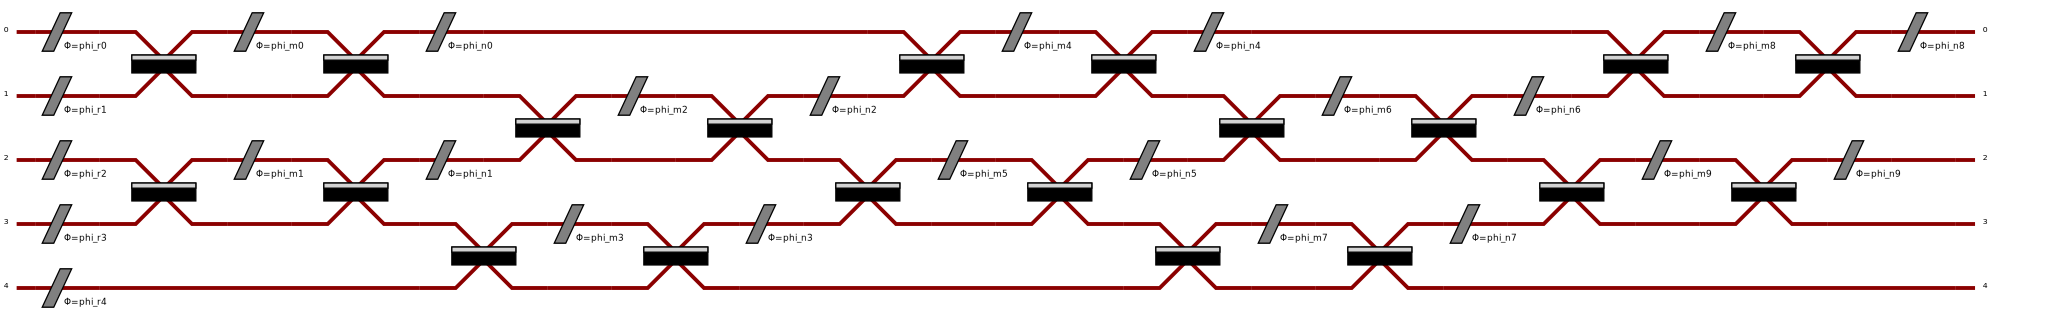

In [10]:
c = Circuit.generic_interferometer(N,
                                        fun_gen=lambda idx: mzi(pcvl.P("phi_m%d" % idx),pcvl.P("phi_n%d" % idx)),
                                        shape="rectangle",
                                        depth=N,
                                        phase_shifter_fun_gen=lambda idx: comp.PS(phi=pcvl.P("phi_r%d" % idx)))
pcvl.pdisplay(c)

### Basinhopping algorithm

In [11]:
def mzi(P1,P2,alpha):
    mz= (Circuit(2, name="mzi")
       .add((0, 1), comp.GenericBS(theta=(45+alpha)/180*np.pi))
       .add(0, comp.PS(P1))
       .add((0, 1), comp.GenericBS(theta=(45+alpha)/180*np.pi))
       .add(0, comp.PS(P2)))
    return mz

In [12]:
def calculate_angle(index_unitary, U_target, alpha):
    start = time.time()
    c = Circuit.generic_interferometer(N,
                                        fun_gen=lambda idx: mzi(pcvl.P("phi_m%d" % idx),pcvl.P("phi_n%d" % idx),alpha),
                                        shape="rectangle",
                                        depth=N,
                                        phase_shifter_fun_gen=lambda idx: comp.PS(phi=pcvl.P("phi_r%d" % idx)))
    params = c.get_parameters()

    # goal is to find phis matching U0 - by minimizing fidelity
    infidelities = []

    for _ in range(n_try):
        init_params = np.random.randn(len(params))
        res = basinhopping(lambda x: infidelity(c, U_target, params, x), init_params, stepsize=0.1, niter=n_iter)
        infidelities.append(res.fun)
    
    return min(infidelities)

In [13]:
n_angles = (abs(angle_min)+abs(angle_max))/angle_step

def discovery_unitary(index_unitary):
    np.random.seed(int(10000*time.time()+os.getpid()) & 0xffffffff)
    U_target = pcvl.Matrix.random_unitary(N)
    l_infidelities = []
    M=angle_min + math.ceil((angle_max-angle_min)/angle_step)*angle_step + 1
    for alpha in tqdm_notebook(range(angle_min,M,angle_step), desc = "Angle progress bar unitary {}".format(index_unitary+1),leave=False):
        l_infidelities.append(calculate_angle(index_unitary, U_target, alpha))
    return l_infidelities

try:
    os.remove("%s-%d.log" % (logfilemzi,N))
except OSError:
    pass

for index_unitary in tqdm_notebook(range(n_unitary), desc = "Unitary progress bar"):
    result = discovery_unitary(index_unitary)
    e = datetime.datetime.now()
    with open("%s-%d.log" % (logfilemzi,N), "a") as f:
        f.write(e.strftime("%Y-%m-%d %H:%M:%S")+"\t")                
        f.write("\t".join(["%g"%inf for inf in result]))
        f.write("\n")

Unitary progress bar:   0%|          | 0/300 [00:00<?, ?it/s]

Angle progress bar unitary 1:   0%|          | 0/24 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Result of the MZI-based scheme

In [ ]:
with open("mzibasednotebook-opt-5.log", "r") as filin:
...     for ligne in filin:
...         print(ligne)

In [ ]:
import numpy as np
L=[]
with open("mzibasednotebook-opt-5.log", "r") as flog:
    for l in flog:
        L.append([float (f) for f in l.strip().split("\t")[1:]])

A=np.asarray(L)
print(A)
print(A.shape)

In [ ]:
Lmin=[]
Lmax=[]
Laverage=[]

for i in range(A.shape[1]):
    Langle = A[:,i]
    Laverage.append(np.average(Langle))
    Langle.sort()
    Lmin.append(np.average(Langle[0:10]))
    Lmax.append(np.average(Langle[-10:]))

print(Laverage)
print(Lmin)
print(Lmax)

### Graph of the infidelity as a function $\alpha$ in degree : MZI-based

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#data
x = np.linspace(-15, 35, len(Laverage))

fig, ax = plt.subplots()

ax.fill_between(x, Lmin, Lmax,alpha=.5,linewidth=0)
ax.plot(x,Laverage,linewidth=2)

ax.set(xlim=(-15, 35),ylim=(min(Lmin), max(Lmax)))
ax.set_yscale('log')


plt.plot(x,Laverage,'r')
plt.title('MZI-based', fontsize=20)
plt.xlabel('alpha in degree', fontsize=15)
plt.ylabel('infidelity 1-F',fontsize=15)


## Our results

For matrices of size 5, we obtained this graph below.

![](../_static/img/bs-notebook5.png)

The MZI-based interferometers are equally sensitive to both positive and negative values of α. The range of tolerance for a correct implementation is of several degrees. For the BS-based interferometers, infidelity behaves rather differently: while for α < 0 the performance of the two are comparable, for α > 0 the BS-based interferometers provide a correct implementation for a much larger range of α (as
large as ∼ 20 degrees). Therefore, the BS-based circuit is more stable than the MZI-based circuit although the BS-based implementation fail at implementing some unitary matrices (like permutation) in the ideal case.

In the article [1], they also performed optimisation on matrices of size 10. We pushed the calculations a bit further on matrices of size 12.

![](../_static/img/bs-notebook12.png)

We only made our computations for the BS-based scheme because we wanted to analyze the stability of this new circuit. We do not have done both yet because it is very time consuming. Indeed, for only one matrix of size 12, the computation takes about 37 hours. Since in our code, we loop over 300 matrices, we get a total time it would take to complete this calculation of roughly 11,100 hours (~460 days) of calculation in total.

To conclude, the BS-based circuit is a very stable scheme but not universal. MZI-based circuit is universal when BS are perfectly manufactured, although it is not possible in practice. However, as one can see on the graphs, the MZI-based circuit is much less robust to errors. In practice, it is common to have $\alpha$ in the range of 5 degress. Thus, the MZI-based circuit is not really universal in practice.

It is therefore necessary to continue to seek relevant criteria to properly evaluate the interferometer schemes.

## References

[1] Suren A Fldzhyan, M Yu Saygin, and Sergei P Kulik. Optimal design of error-tolerant reprogrammable multiport interferometers. [Optics Letters](https://doi.org/10.1364/OL.385433), 45(9):2632–2635, 2020.

[2]: Michael Reck, Anton Zeilinger, Herbert J Bernstein, and Philip Bertani. Experimental realization of any discrete unitary operator. [Physical review letters](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.73.58), 73(1):58, 1994.